In [ ]:
!pip install openai pandas scikit-learn tensorflow
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1


In [ ]:
import pandas as pd
import os
import openai
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import numpy as np

os.environ["OPENAI_API_KEY"] ="" # Enter your key
openai.api_key = os.environ["OPENAI_API_KEY"]

df = pd.read_csv("") # Enter your dataset path
df = df.dropna(subset=["title", "description", "estimated_hours"])
df["input_text"] = df["title"] + ": " + df["description"]

In [ ]:
def get_openai_embeddings(texts, model="text-embedding-ada-002", batch_size=50):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        response = openai.Embedding.create(model=model, input=batch)
        batch_embeddings = [item['embedding'] for item in response['data']]
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

In [ ]:
sample_df = df.sample(n=1000, random_state=42).reset_index(drop=True)
X_embed = get_openai_embeddings(sample_df["input_text"].tolist())
y = sample_df["estimated_hours"].values

In [ ]:
from tensorflow.keras import layers, models

# data spliting
X_train, X_val, y_train, y_val = train_test_split(X_embed, y, test_size=0.2, random_state=42)

# DNN
model = models.Sequential([
    layers.Input(shape=(X_embed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# training
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.6826 - mae: 3.7043 - val_loss: 5.6226 - val_mae: 2.0613
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7704 - mae: 2.0684 - val_loss: 5.7284 - val_mae: 2.0742
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.1079 - mae: 1.9273 - val_loss: 5.6343 - val_mae: 2.0628
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.0092 - mae: 1.9189 - val_loss: 5.6057 - val_mae: 2.0626
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8605 - mae: 1.8948 - val_loss: 5.6342 - val_mae: 2.0624
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9381 - mae: 1.9162 - val_loss: 5.6144 - val_mae: 2.0648
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8541 - mae: 1.8890 - val_loss: 5.6556 - val_mae: 2.0670
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8887 - mae: 1.8994 - val_loss: 5.6829 - val_mae: 2.0686
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6496 

In [ ]:
# dnn output
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

X_train_rf = np.hstack([X_train, train_preds])
X_val_rf = np.hstack([X_val, val_preds])
# save DNN
model.save("duration_estimator_dnn_model.h5")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:

# random forrest training
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)
import joblib

# save RF
joblib.dump(rf_model, "duration_rf_model.pkl")

['duration_rf_model.pkl']

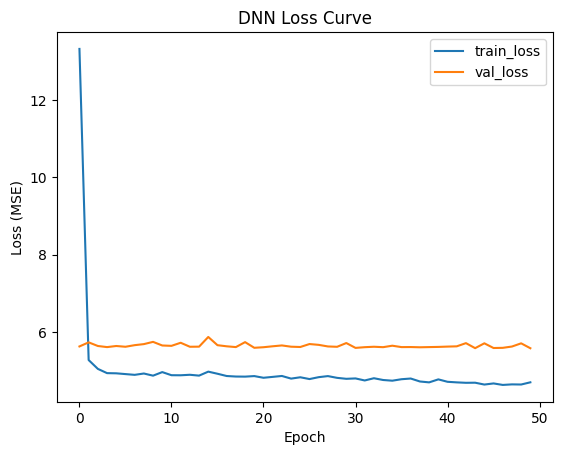

In [ ]:
# loss function plot
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("DNN Loss Curve")
plt.show()

# example

In [ ]:
# usage function
def estimate_duration(title, description):
    full_text = title + ". " + description
    emb = get_openai_embeddings([full_text])[0]
    emb_array = np.array(emb).reshape(1, -1)

    dnn_pred = model.predict(emb_array).flatten()[0]

    rf_input = np.hstack([emb_array, [[dnn_pred]]])
    final_pred = rf_model.predict(rf_input)[0]

    return round(final_pred, 2)

In [ ]:
# example usage
title = "Prepare PowerPoint Slides"
description = "Design and create 10 slides for AI in education seminar. Include charts and references."


predicted_hours = estimate_duration(title, description)
print(f" Predicted Duration: {predicted_hours} hours")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
 Predicted Duration: 4.74 hours


# COMPARSION
DNN ONLY vs RF ONLY vs DNN( mid train pred + output) -> RF


In [ ]:
!pip install openai scikit-learn matplotlib tensorflow --quiet

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


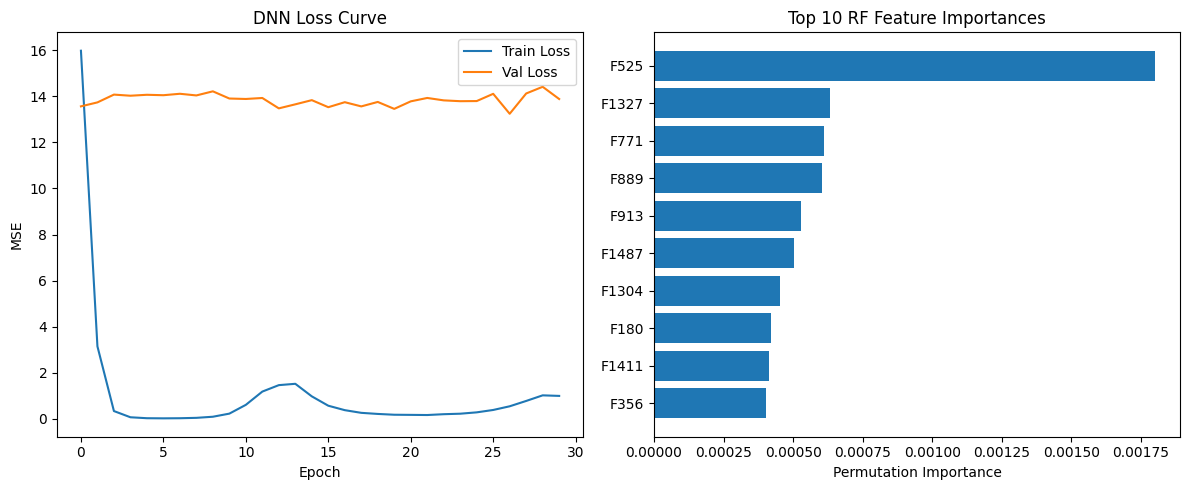

{'DNN_MSE': 13.884, 'RF_Baseline_MSE': 10.757, 'RF_Enhanced_MSE': 14.177}


In [ ]:
import openai
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense

# === OpenAI embedding ===
X_embed = np.random.rand(1000, 1536)
y = np.random.uniform(0.5, 12.0, size=1000)

# data spliting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embed)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === DNN ===
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

# define output and mid layer
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x_mid = Dense(64, activation='relu')(x)
output_layer = Dense(1)(x_mid)

# modle build
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16, verbose=0)

# === baseline 1：DNN only ===
dnn_pred_val = model.predict(X_val)
dnn_mse = mean_squared_error(y_val, dnn_pred_val)

# === baseline 2： RF only ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred_val = rf.predict(X_val)
rf_mse = mean_squared_error(y_val, rf_pred_val)

# === Enhanced RF：DNN mid train pred + output -> rf  ===
intermediate_model = Model(inputs=model.input, outputs=model.layers[-2].output)
mid_train = intermediate_model.predict(X_train)
mid_val = intermediate_model.predict(X_val)

dnn_train_pred = model.predict(X_train)
enh_train = np.hstack([X_train, mid_train, dnn_train_pred])
enh_val = np.hstack([X_val, mid_val, dnn_pred_val])

rf_enh = RandomForestRegressor(n_estimators=100, random_state=42)
rf_enh.fit(enh_train, y_train)
enh_pred = rf_enh.predict(enh_val)
enh_mse = mean_squared_error(y_val, enh_pred)

# === feature importance ===
perm_result = permutation_importance(rf_enh, enh_val, y_val, n_repeats=10, random_state=42)
top10 = np.argsort(perm_result.importances_mean)[-10:]

# === visualize ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('DNN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.barh(range(10), perm_result.importances_mean[top10])
plt.yticks(range(10), [f"F{i}" for i in top10])
plt.title("Top 10 RF Feature Importances")
plt.xlabel("Permutation Importance")

plt.tight_layout()
plt.show()

# === result ===
print({
    "DNN_MSE": round(dnn_mse, 3),
    "RF_Baseline_MSE": round(rf_mse, 3),
    "RF_Enhanced_MSE": round(enh_mse, 3)
})

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


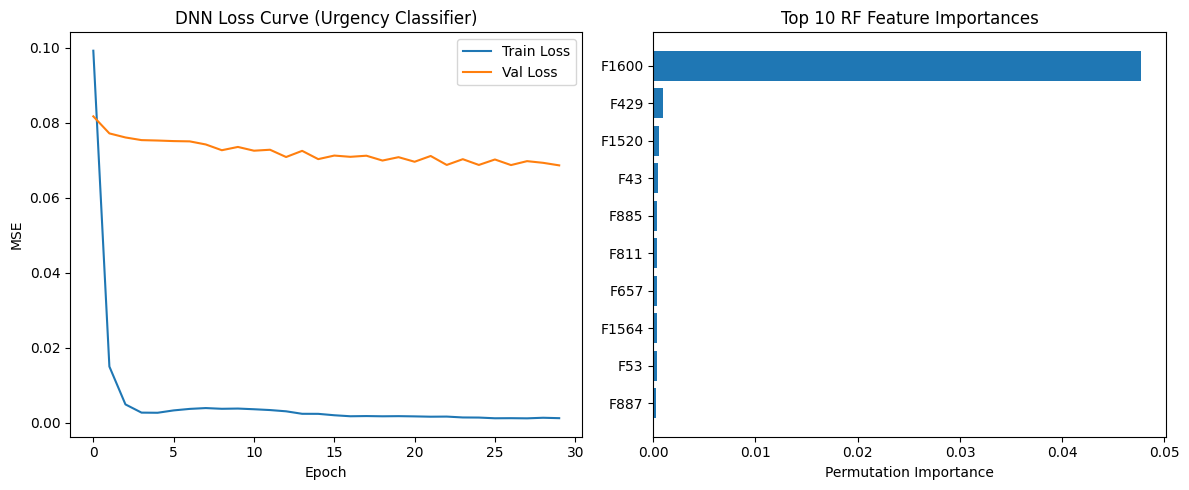

{'DNN_MSE': 0.0686, 'RF_Baseline_MSE': 0.0649, 'RF_Enhanced_MSE': 0.0685}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

# === 1. Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/Synthetic_Task_Dataset.csv")
df["input_text"] = df["title"] + " " + df["description"]
sample_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# === 2. Use urgency_level as target (regression) ===
y = sample_df["urgency_level"].values

# === 3. Mock embedding（OpenAI embedding placeholder）===
X_embed = np.random.rand(len(sample_df), 1536)

# === 4. Split & scale ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embed)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === 5. DNN ===
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x_mid = Dense(64, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x_mid)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16, verbose=0)

dnn_pred_val = model.predict(X_val)
dnn_mse = mean_squared_error(y_val, dnn_pred_val)

# === 6. RF baseline ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred_val = rf.predict(X_val)
rf_mse = mean_squared_error(y_val, rf_pred_val)

import joblib

# save RF
joblib.dump(rf_model, "rf_model.pkl")

# === 7. RF Enhanced (DNN mid + output) ===
intermediate_model = Model(inputs=model.input, outputs=x_mid)
mid_train = intermediate_model.predict(X_train)
mid_val = intermediate_model.predict(X_val)
dnn_train_pred = model.predict(X_train)

enh_train = np.hstack([X_train, mid_train, dnn_train_pred])
enh_val = np.hstack([X_val, mid_val, dnn_pred_val])

rf_enh = RandomForestRegressor(n_estimators=100, random_state=42)
rf_enh.fit(enh_train, y_train)
enh_pred = rf_enh.predict(enh_val)
enh_mse = mean_squared_error(y_val, enh_pred)

# === 8. Feature importance ===
perm_result = permutation_importance(rf_enh, enh_val, y_val, n_repeats=10, random_state=42)
top10 = np.argsort(perm_result.importances_mean)[-10:]

# === 9. Plot results ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('DNN Loss Curve (Urgency Classifier)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.barh(range(10), perm_result.importances_mean[top10])
plt.yticks(range(10), [f"F{i}" for i in top10])
plt.title("Top 10 RF Feature Importances")
plt.xlabel("Permutation Importance")

plt.tight_layout()
plt.show()

# === 10. Summary ===
print({
    "DNN_MSE": round(dnn_mse, 4),
    "RF_Baseline_MSE": round(rf_mse, 4),
    "RF_Enhanced_MSE": round(enh_mse, 4)
})

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

# === 1. Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/Synthetic_Task_Dataset.csv")
df["input_text"] = df["title"] + " " + df["description"]
sample_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# === 2. Use urgency_level as target (regression) ===
y = sample_df["urgency_level"].values

# === 3. Mock embedding（OpenAI embedding placeholder）===

sample_texts = sample_df["input_text"].tolist()
X_embed = get_openai_embeddings(sample_texts)  # shape = (1000, 1536)

# === 4. Split & scale ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embed)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred_val = rf.predict(X_val)
rf_mse = mean_squared_error(y_val, rf_pred_val)

import joblib

# save RF
joblib.dump(rf, "urgency_rf_model.pkl")

['urgency_rf_model.pkl']